In [1]:
import os
import json
import torch
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import custom_utils.data_conversion as data_conversion
import custom_utils.depth_anything_interface as depth_anything_interface
import numpy as np

MODEL_TYPE = "base"
ENCODER = "vitl"
DATAFILE = "/scratchdata/moving_2L"
CAMERA_JSON = "/scratchdata/gemini_2l.json"
MODEL_PATH = f"/scratchdata/depth_anything_v2_{ENCODER}.pth"
with open(CAMERA_JSON, 'r') as f:
    CAMERA_DATA = json.load(f)
FRAME_INDEX = 40
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
MODEL = depth_anything_interface.get_model(DEVICE, MODEL_PATH, model_type = MODEL_TYPE, encoder=ENCODER)

xFormers not available
xFormers not available
/depth-stereo/scripts/custom_utils/depth_anything_interface.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_sta

In [2]:
# Open bag file
bag_file_path = os.path.join(DATAFILE, "raw.bag")
bag = rosbag.Bag(bag_file_path)

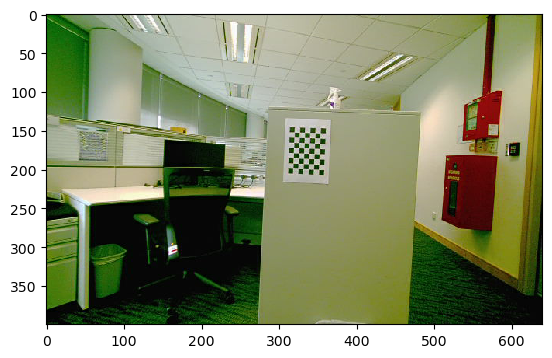

In [3]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    if wait == FRAME_INDEX:
        img = data_conversion.topic_to_image(msg)
        break
    wait += 1

plt.imshow(img)

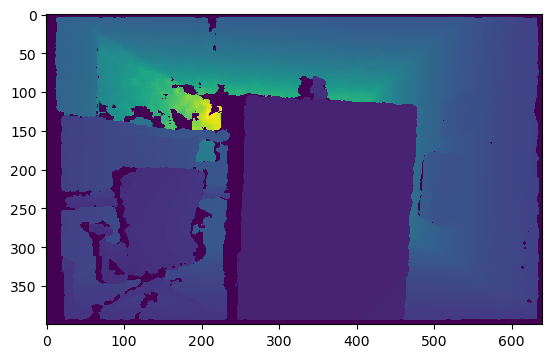

In [4]:
wait = 0

for topic, msg, t in bag.read_messages(topics=["/camera/depth/image_raw"]):
    if wait == FRAME_INDEX:
        depth = data_conversion.topic_to_depth(msg, CAMERA_DATA)
        break
    wait += 1

plt.imshow(depth)

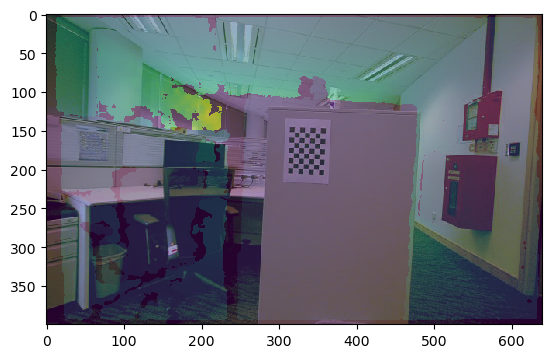

In [5]:
# Overlay image overdepth at half alpha
plt.imshow(depth)
plt.imshow(img, alpha=0.5)

a: 1291.782176074757, b: 215.82735146021253, c: -1.0978331954085812
R2: 0.7903375761180158


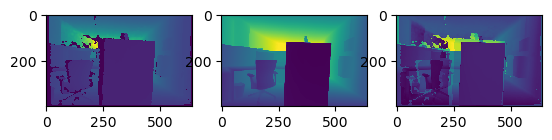

In [6]:
est_depth = MODEL.infer_image(np.array(img)) # HxW raw depth map in numpy

pred_depth, popt = depth_anything_interface.get_pred_depth(depth, est_depth, CAMERA_DATA, verbose=True)

fig, axs = plt.subplots(1, 3)

depth_normalised = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))
pred_normalised = (pred_depth - np.min(pred_depth)) / (np.max(pred_depth) - np.min(pred_depth))

axs[0].imshow(depth_normalised)
axs[1].imshow(pred_normalised)
diff = abs(depth_normalised - pred_normalised)
axs[2].imshow(diff)

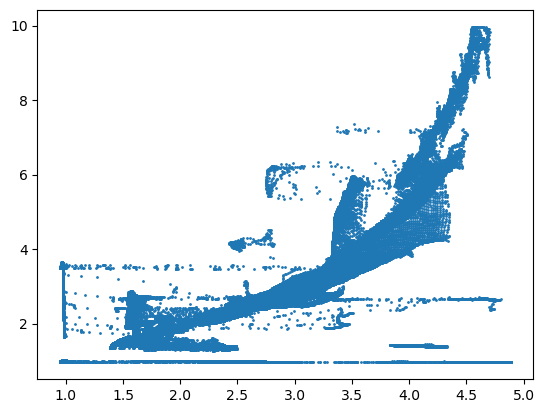

In [7]:
depth_flatten = depth.flatten()
est_depth_flatten = est_depth.flatten()
#Ignore pixels with 0 depth in depth image
est_depth_flatten = est_depth_flatten[depth_flatten!=CAMERA_DATA["min_range"]]
depth_flatten = depth_flatten[depth_flatten!=CAMERA_DATA["min_range"]]

plt.scatter(depth_anything_interface.estimated_depth_model(est_depth_flatten, popt[0], popt[1], popt[2]), depth_flatten, s=1)